# Remove data from 9/11

In [1]:
# execute if not installed
import sys
import os 
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
data_path = 'data/finance_datasets/stock_data/'
df_list = []
cols = []
for fname in os.listdir(data_path):
    df = pd.read_csv(data_path + fname)
    df['Date'] = pd.to_datetime(df['Date'])
    cols.append(fname)
    df_list.append(df)

cols = [w.split('.')[0] for w in cols]

In [4]:
date_start = np.datetime64('2001-05-29')
date_end = np.datetime64('2001-12-25')

for i, df in enumerate(df_list):
    idx = (df['Date'] >= date_start) & (df['Date'] <= date_end)
    df_list[i] = df.loc[idx, :][['Date', 'Adj Close']]
    df_list[i]['Day'] = (df_list[i]['Date'] - df_list[i]['Date'].iloc[0]).dt.days.values

In [5]:
data = []
for df in df_list:
    data.append(mogptk.Data(X=df['Day'].values, Y=df['Adj Close'].values))
    
for d in data:
    d.transform(mogptk.TransformDetrend)

In [6]:
data[0].remove_range(df['Day'].iloc[-1], None)

for i in range(1, len(cols)):
     data[i].remove_range(100, 130)

# add pred values

# use data class
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df_list[i]['Adj Close'].values[~data[i].mask] for i in range(len(cols))]

#  MOSM

In [7]:
%%time
n_trials = 1

mosm_list = []
mosm_mae = np.zeros((n_trials, len(df_list)))
mosm_mape = np.zeros((n_trials, len(df_list)))
mosm_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    model_mosm = mogptk.MOSM(data, Q=4)
    model_mosm.init_params('BNSE')
    model_mosm.build()
    
    print('Starting trial', n)
    model_mosm.train(method='L-BFGS-B',
                     maxiter=3000,
                     tol=1e-50)
    print('Finished trial', n)
    print('='*50)        
    mosm_list.append(model_mosm)
    # errors per channel
    error = mogptk.test_errors(model_mosm, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1177.689359
  Number of iterations: 3000
  Number of functions evaluations: 3181
Done in  24.476438331604005  minutes
Finished trial 0
CPU times: user 31min 57s, sys: 2min 52s, total: 34min 49s
Wall time: 27min 17s


In [8]:
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.455529,0.018985,0.455529,0.0,0.0,0.0
1,1.630154,0.080149,1.895227,0.0,0.0,0.0
2,0.411867,0.019855,0.502369,0.0,0.0,0.0
3,2.023811,0.117501,2.257474,0.0,0.0,0.0
4,1.962259,0.057915,2.305281,0.0,0.0,0.0
5,2.361132,0.165004,2.688255,0.0,0.0,0.0
6,74.864846,0.067918,92.496730,0.0,0.0,0.0
7,2.220062,0.114107,2.764306,0.0,0.0,0.0
8,41.822837,0.121794,50.791630,0.0,0.0,0.0


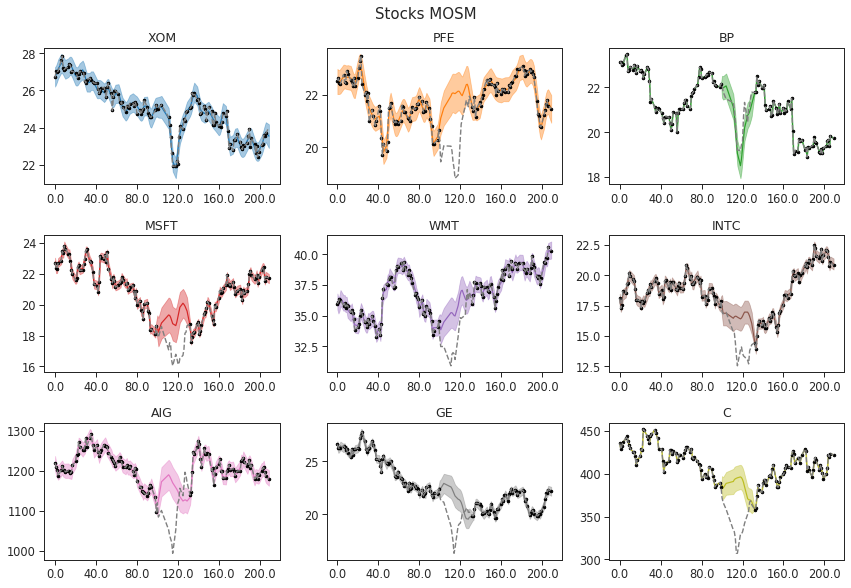

In [11]:
best_model = mosm_list[np.argmin(mosm_mape.mean(1))]
model_mosm.plot_prediction(grid=(3, 3), names=cols, title='Stocks MOSM');

# CSM

In [20]:
%%time
n_trials = 1

csm_mae = np.zeros((n_trials, len(df_list)))
csm_mape = np.zeros((n_trials, len(df_list)))
csm_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    model_csm = mogptk.CSM(data, Q=4)
    model_csm.init_params('BNSE')
    
    print('Starting trial', n)
    model_csm.build()
    model_csm.train(method='L-BFGS-B',
                    maxiter=3000,
                    tol=1e-20)
    print('Finished trial', n)
    print('='*50)
    
    # errors per channel
    error = mogptk.test_errors(model_csm, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Starting trial 0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 1819.932591
  Number of iterations: 3000
  Number of functions evaluations: 3243
Done in  10.44499728679657  minutes
Finished trial 0
CPU times: user 17min 28s, sys: 1min 56s, total: 19min 24s
Wall time: 12min 27s


In [18]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0


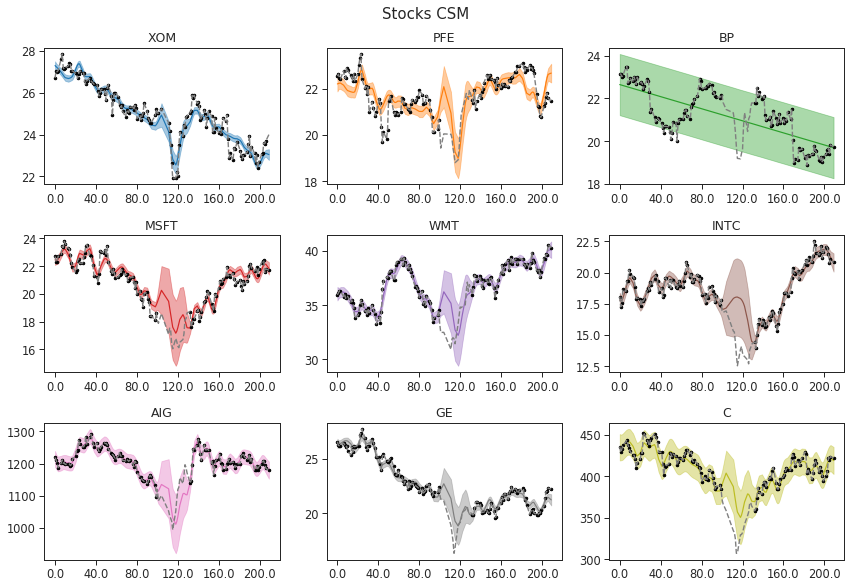

In [21]:
model_csm.plot_prediction(grid=(3, 3), names=cols, title='Stocks CSM');

# SM-LMC

In [24]:
%%time
n_trials = 1

smlmc_mae = np.zeros((n_trials, len(df_list)))
smlmc_mape = np.zeros((n_trials, len(df_list)))
smlmc_rmse = np.zeros((n_trials, len(df_list)))

for n in range(n_trials):
    print('Trial ', n)
    model_smlmc = mogptk.SM_LMC(data, Q=4)
    model_smlmc.init_params('BNSE')
    
    model_smlmc.build()
    
    model_smlmc.train(method='L-BFGS-B',
                      maxiter=3000,
                      tol=1e-20)
    
    error = mogptk.test_errors(model_smlmc, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

Trial  0
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SpectralMixtureLMC-2d751442-82/constant/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n  

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SpectralMixtureLMC-b3ca2b29-78/constant/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n           

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SpectralMixtureLMC-cf6a85d1-88/constant/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n           

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SpectralMixtureLMC-ac049b27-94/constant/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n           

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-9e7172a5-108/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n                      tol=1e-50,

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Noise-8de169b3-100/noise/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/alecuevas/.conda/envs/tfgpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3316, in run_code
    return outflag  File "<ipython-input-22-dd7e2f06272a>", line 1, in <module>
    get_ipython().run_cell_magic('time', '', "n_trials = 1\n\nsmlmc_mae = np.zeros((n_trials, len(df_list)))\nsmlmc_mape = np.zeros((n_trials, len(df_list)))\nsmlmc_rmse = np.zeros((n_trials, len(df_list)))\n\nfor n in range(n_trials):\n    print('Trial ', n)\n    model_smlmc = mogptk.SM_LMC(data, Q=4)\n    model_smlmc.init_params('BNSE')\n    \n    model_smlmc.build()\n    \n    model_smlmc.train(method='L-BFGS-B',\n                      maxiter=4000,\n                      tol=

In [25]:
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE%', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'],
             index=cols)

,MAE,MAPE%,RMSE,MAE std,MAPE% std,RMSE std
XOM,0.606424,0.025274,0.606424,0.0,0.0,0.0
PFE,0.824083,0.040517,1.063871,0.0,0.0,0.0
BP,0.531566,0.025625,0.617593,0.0,0.0,0.0
MSFT,2.762643,0.160398,3.171932,0.0,0.0,0.0
WMT,3.392957,0.100142,3.964565,0.0,0.0,0.0
INTC,4.994785,0.349052,5.775892,0.0,0.0,0.0
AIG,55.840709,0.050659,70.884862,0.0,0.0,0.0
GE,1.603599,0.082422,2.166825,0.0,0.0,0.0
C,48.221739,0.140429,55.297835,0.0,0.0,0.0


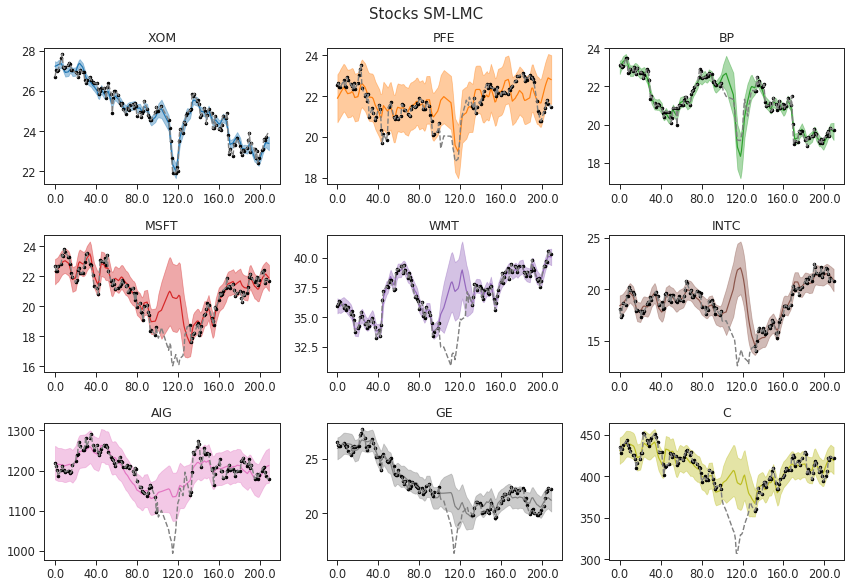

In [26]:
model_smlmc.plot_prediction(grid=(3, 3), names=cols, title='Stocks SM-LMC');

# Comparison

In [ ]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean())